<br>
<img src="data/logo.png" alt="Logo" style="width:300px"/><br>

# **Food Delivery Case**<br>

### 👨‍💻 Jorge Gómez Galván
* LinkedIn: [linkedin.com/in/jorgeggalvan/](https://www.linkedin.com/in/jorgeggalvan/) 
* E-mail: ggalvanjorge@gmail.com

<div style="border: 5px solid rgba(4, 100, 159, 1); padding: 20px; font-size: 16px; color: #1F2E4E; background-color: rgba(249, 206, 29, 0.2);">
<b>Just Delivery</b> (empresa ficticia) es una compañía de servicios dedicada a la distribución de comida a domicilio (similar a Glovo, Just Eat, Uber Eats, etc.). La empresa opera con una red de restaurantes asociados que pueden tener o no su propio servicio de distribución (delivery).
<br><br>
El equipo comercial de Just Delivery trabaja continuamente para incorporar nuevas empresas a su red de restaurantes asociados. Al ser su capacidad limitada, se ha identificado la necesidad de desarrollar un método analítico que permita estimar el potencial de una ciudad, a modo de poder planificar cuáles son las ciudades a priorizar en cada mes.
</div>

---
## **1 - 🥡 Tratamiento del dataset**

In [1]:
# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from geopy.exc import GeocoderTimedOut
from geopy.geocoders import Nominatim

import warnings
warnings.filterwarnings('ignore')

# Librerías de Machine Learning
from sklearn.model_selection import train_test_split

from lazypredict.Supervised import LazyRegressor
from lazypredict.Supervised import LazyClassifier

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import shap

In [2]:
# Lectura del dataset
df = pd.read_csv('./data/dataset_justdelivery.csv')

<table style="border: 1px solid black; border-collapse: collapse;">
  <tr>
    <th style="border: 1px solid black; padding: 8px;">Campo</th>
    <th style="border: 1px solid black; padding: 8px;">Definición</th>
  </tr>
  <tr>
    <td style="border: 1px solid black; padding: 8px;"><b>city</b></td>
    <td style="border: 1px solid black; padding: 8px;">Nombre de la ciudad</td>
  </tr>
  <tr>
    <td style="border: 1px solid black; padding: 8px;"><b>population</b></td>
    <td style="border: 1px solid black; padding: 8px;">Población</td>
  </tr>
  <tr>
    <td style="border: 1px solid black; padding: 8px;"><b>orders</b></td>
    <td style="border: 1px solid black; padding: 8px;">Pedidos mensuales actualmente en Just Delivery</td>
  </tr>
  <tr>
    <td style="border: 1px solid black; padding: 8px;"><b>density</b></td>
    <td style="border: 1px solid black; padding: 8px;">Número de habitantes dividido por kilómetros cuadrados</td>
  </tr>
  <tr>
    <td style="border: 1px solid black; padding: 8px;"><b>avg_income</b></td>
    <td style="border: 1px solid black; padding: 8px;">Ingreso promedio por persona</td>
  </tr>
  <tr>
    <td style="border: 1px solid black; padding: 8px;"><b>total_restaurants</b></td>
    <td style="border: 1px solid black; padding: 8px;">Número total de restaurantes en la ciudad</td>
  </tr>
  <tr>
    <td style="border: 1px solid black; padding: 8px;"><b>total_restaurants_onboarded</b></td>
    <td style="border: 1px solid black; padding: 8px;">Número total de restaurantes que trabajan actualmente con Just Delivery en la ciudad</td>
  </tr>
  <tr>
    <td style="border: 1px solid black; padding: 8px;"><b>self_delivery_restaurants</b></td>
    <td style="border: 1px solid black; padding: 8px;">Número de restaurantes que cuentan actualmente con capacidad de delivery propia</td>
  </tr>
  <tr>
    <td style="border: 1px solid black; padding: 8px;"><b>self_delivery_restaurants_onboarded</b></td>
    <td style="border: 1px solid black; padding: 8px;">Número de restaurantes con capacidad de delivery propia en la ciudad que trabajan actualmente con Just Delivery</td>
  </tr>
  <tr>
    <td style="border: 1px solid black; padding: 8px;"><b>non_self_delivery_restaurants</b></td>
    <td style="border: 1px solid black; padding: 8px;">Número de restaurantes sin capacidad de delivery propia en la ciudad</td>
  </tr>
  <tr>
    <td style="border: 1px solid black; padding: 8px;"><b>non_self_delivery_restaurants_onboarded</b></td>
    <td style="border: 1px solid black; padding: 8px;">Número de restaurantes sin capacidad de delivery propia en la ciudad que trabajan actualmente con Just Delivery</td>
  </tr>
</table>

In [3]:
# Cambio de nombre de variables
df = df.rename(columns={'city':'ciudad', 
                        'population':'poblacion', 
                        'orders':'pedidos', 
                        'density':'densidad', 
                        'avg_income':'ingreso_medio',
                        'total_restaurants':'total_rest', 
                        'total_restaurants_onboarded':'total_rest_fidelizados',
                        'self_delivery_restaurants':'n_rest_delivery',
                        'self_delivery_restaurants_onboarded':'n_rest_fidelizados_delivery',
                        'non_self_delivery_restaurants':'n_rest_no_delivery',
                        'non_self_delivery_restaurants_onboarded':'n_rest_fidelizados_no_delivery'})

# Nº de pedidos por restaurante fidelizado en la ciudad
df['n_pedidos_por_rest'] = round(df['pedidos'] / df['total_rest_fidelizados'],2).replace([np.inf, -np.inf], np.nan).fillna(0) # Se reemplazan los valores infinitos por 0

# Población por restaurante y por restaurante fidelizado
df['poblacion_por_rest'] = round(df['poblacion'] / df['total_rest'],2)
df['poblacion_por_rest_fidelizado'] = round(df['poblacion'] / df['total_rest_fidelizados'],2).replace([np.inf, -np.inf], np.nan).fillna(0) # Se reemplazan los valores infinitos por 0

# Porcentaje de restaurantes fidelizados vs. totales
df['p_rest_fidelizados'] = round(df['total_rest_fidelizados'] / df['total_rest'],2)

# Sería interesante poder contar con más variables como el ticket medio por pedido o el ingreso medio por restaurante

### 1.1 - Coordenadas

In [4]:
# Geolocalizador 
geolocator = Nominatim(user_agent="myGeocoder", timeout=99999)

ciudades = df['ciudad'].unique() # Nombres de ciudades únicas
coordenadas = {} # Diccionario vacío para almacenar las coordenadas de cada ciudad

# Bucle para obtener la latitud y longitud de las ciudades
for ciudad in ciudades:
    try:
        # Ubicación geográfica de la ciudad utilizando el método 'geocode'
        localizacion = geolocator.geocode(ciudad)
        # Latitud y longitud si se encuentra la ubicación
        coordenadas[ciudad] = (localizacion.latitude, localizacion.longitude)
    except AttributeError:
        # 'NA' en lugar de las coordenadas si no se encuentra la ubicación
        coordenadas[ciudad] = "NA"

# Dataframe con las ciudades y sus coordenadas
df_ciudades = pd.DataFrame(coordenadas.items(), columns=['ciudad','coordenadas'])

In [5]:
# Ciudades que no se han podido obtener sus coordenadas
df_ciudades[df_ciudades['coordenadas'] == 'NA']

,ciudad,coordenadas
204,Almu?écar,NA
476,Lli?à d'Amunt,NA
640,"Palma del Condado, La",NA
642,Sabi?ánigo,NA
659,"Roca del Vallès, La",NA
684,Fernán-N?ñez,NA
808,Peníscola/Pe?íscola,NA


In [6]:
# Actualización manual de las coordenadas para las ciudades que no se pudieron obtener automáticamente
df_ciudades.loc[48, 'coordenadas'] = (36.1667, -5.3500)
df_ciudades.loc[204, 'coordenadas'] = (36.7324, -3.6893)
df_ciudades.loc[476, 'coordenadas'] = (41.5992, 2.2533) 
df_ciudades.loc[640, 'coordenadas'] = (37.4818, -6.5402) 
df_ciudades.loc[642, 'coordenadas'] = (42.5160, -0.3675)
df_ciudades.loc[659, 'coordenadas'] = (41.5908, 2.2896)
df_ciudades.loc[684, 'coordenadas'] = (37.6835, -4.6415)
df_ciudades.loc[808, 'coordenadas'] = (40.3605, 0.4029)

In [7]:
# División de coordenadas en latitud y longitud
df_ciudades[['latitud','longitud']] = pd.DataFrame(df_ciudades['coordenadas'].tolist(), index=df_ciudades.index)
# Eliminación de la columna 'coordenadas'
df_ciudades.drop(['coordenadas'], axis=1, inplace=True)

# Conversión a tipo float
df_ciudades['latitud'] = df_ciudades['latitud'].astype(float)
df_ciudades['longitud'] = df_ciudades['longitud'].astype(float)

# Unión de latitud y longitud con el dataframe original
df = df.merge(df_ciudades, how='left', left_on='ciudad', right_on='ciudad')

### 1.2 - Comunidades autónomas

In [8]:
# Función que devuelve el nombre de la comunidad autónoma en función del nombre de la ciudad
def get_comunidad_autonoma(ciudad):
    
    # Geolocalizador 
    geolocator = Nominatim(user_agent="myGeocoder", timeout=99999)
    
    try:
        # Ubicación geográfica de la ciudad
        location = geolocator.geocode(ciudad+", Spain", exactly_one=True, addressdetails=True, language="es")
        address = location.raw['address']
        
        # Comprobación de que la ubicación incluya el nombre de la comunidad autónoma en la clave 'state'
        if 'state' in address:
            return address['state']
        # Comprobación de que la ubicación incluya el nombre de la comunidad autónoma en la clave 'state_district'
        elif 'state_district' in address:
            return address['state_district']
        # Devolución de 'NA' si no se encuentra en ninguna de las claves anteriores
        else:
            return 'NA'
    # Devolución de 'NA' si se produce un error en la solicitud de geolocalización
    except (AttributeError, GeocoderTimedOut):
        return 'NA'

# Aplicación de la función 'get_comunidad_autonoma'
df['comunidad_autonoma'] = df['ciudad'].apply(lambda x: get_comunidad_autonoma(x))

In [9]:
# Ciudades que no se han podido obtener su comunidad autónoma
cond_na = df['comunidad_autonoma'] == 'NA'
cond_melilla = df['comunidad_autonoma'] == 'Melilla'
cond_ceuta = df['comunidad_autonoma'] == 'Plazas de Soberanía'
             
df[cond_na | cond_melilla | cond_ceuta][['ciudad','comunidad_autonoma']]

,ciudad,comunidad_autonoma
23,Melilla,Melilla
24,Ceuta,Plazas de Soberanía
204,Almu?écar,NA
393,G?ímar,NA
476,Lli?à d'Amunt,NA
568,Sada,NA
589,Eg?és,NA
642,Sabi?ánigo,NA
684,Fernán-N?ñez,NA
689,Gri?ón,NA


In [10]:
# Actualización manual de las comunidades autónomas para las ciudades que no se pudieron obtener automáticamente
df.loc[23,'comunidad_autonoma'] = 'Ceuta y Melilla'
df.loc[24,'comunidad_autonoma'] = 'Ceuta y Melilla'
df.loc[204,'comunidad_autonoma'] = 'Andalucía'
df.loc[393,'comunidad_autonoma'] = 'Santa Cruz de Tenerife'
df.loc[476,'comunidad_autonoma'] = 'Cataluña'
df.loc[568,'comunidad_autonoma'] = 'Galicia'
df.loc[589,'comunidad_autonoma'] = 'Navarra'
df.loc[642,'comunidad_autonoma'] = 'Aragón'
df.loc[684,'comunidad_autonoma'] = 'Andalucía'
df.loc[689,'comunidad_autonoma'] = 'Comunidad de Madrid'
df.loc[808,'comunidad_autonoma'] = 'Comunidad Valenciana'
df.loc[980,'comunidad_autonoma'] = 'Cataluña'

In [11]:
df.sample(5)

,ciudad,poblacion,pedidos,densidad,ingreso_medio,total_rest,total_rest_fidelizados,n_rest_delivery,n_rest_fidelizados_delivery,n_rest_no_delivery,n_rest_fidelizados_no_delivery,n_pedidos_por_rest,poblacion_por_rest,poblacion_por_rest_fidelizado,p_rest_fidelizados,latitud,longitud,comunidad_autonoma
213,Candelaria,26889,29,1777.80,21164.00,105,1,10,1,95,0,29.00,256.09,26889.00,0.01,10.49,-74.87,Santa Cruz de Tenerife
651,Villalbilla,10465,45,303.00,32859.00,15,0,1,0,14,0,0.00,697.67,0.00,0.00,40.43,-3.30,Comunidad de Madrid
779,Sentmenat,8407,15,297.00,26839.00,33,0,1,0,32,0,0.00,254.76,0.00,0.00,41.61,2.14,Cataluña
494,Cambados,14071,0,1388.40,25138.67,85,0,1,0,84,0,0.00,165.54,0.00,0.00,42.51,-8.81,Galicia
650,Caudete,10477,4,74.00,18443.00,25,0,3,0,22,0,0.00,419.08,0.00,0.00,38.71,-0.99,Castilla-La Mancha


---
## **2 - 🔎 Análisis exploratorio de datos**

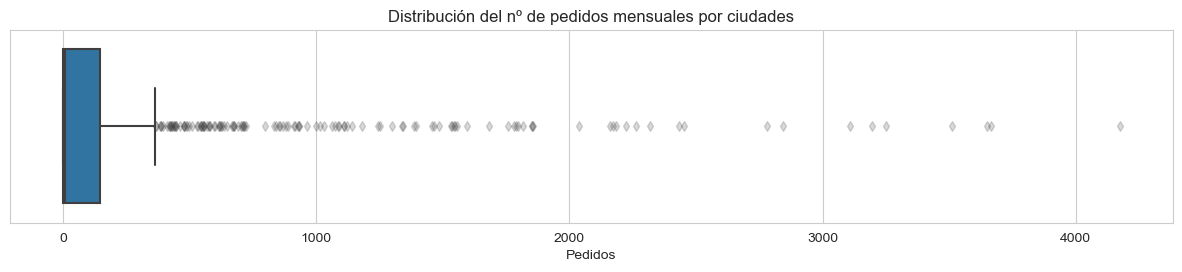

In [12]:
# Boxplot con la distribución del nº de pedidos mensuales por ciudad
sns.set_style('whitegrid')
sns.boxplot(x=df['pedidos'], flierprops={'alpha':0.2})
plt.gcf().set_size_inches(15,2.5) # Ajuste del tamaño del gráfico

# Título y etiqueta del eje
plt.title('Distribución del nº de pedidos mensuales por ciudades')
plt.xlabel('Pedidos')

plt.show()

<div style="border: 5px solid rgba(4, 100, 159, 1); padding: 20px; font-size: 16px; color: #1F2E4E; background-color: rgba(249, 206, 29, 0.2);">
Una vez incluidas todas las nuevas variables en el dataframe, se ha calculado la matriz de correlación para analizar las relaciones lineales y detectar posibles problemas de multicolinealidad entre las diferentes variables.
</div>

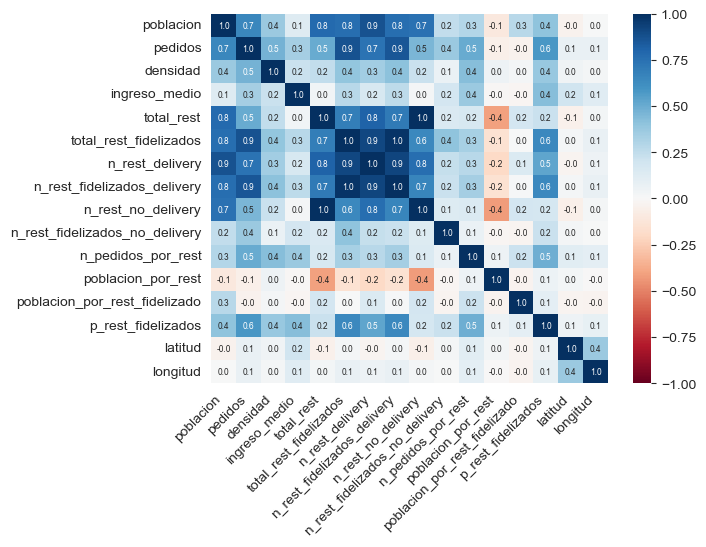

In [13]:
# Matriz de correlación
numerical = df.select_dtypes(exclude = 'object') # Selección de variables numéricas
corr_matrix = numerical.corr()

# Mapa de calor con la matriz de correlación
sns.heatmap(corr_matrix, vmin=-1, cmap='RdBu', annot=True, annot_kws={"size": 6}, fmt='.1f')
plt.xticks(rotation=45, ha='right')
plt.show()

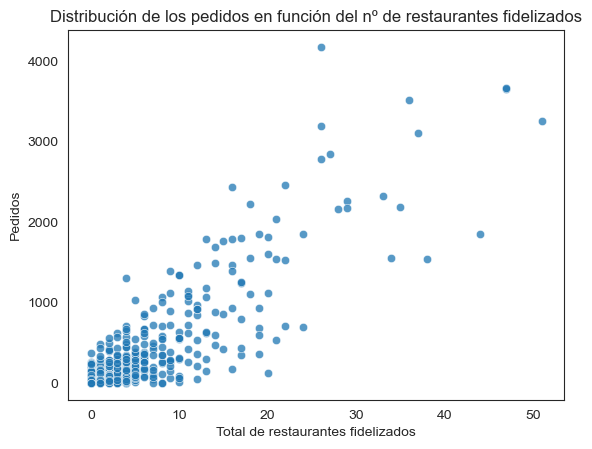

In [14]:
# Distribución de los pedidos en función del nº de restaurantes fidelizados
sns.set_style('white')
sns.scatterplot(x='total_rest_fidelizados', y='pedidos', data=df, alpha=0.75);

# Título y etiquetas de los ejes
plt.title('Distribución de los pedidos en función del nº de restaurantes fidelizados')
plt.xlabel('Total de restaurantes fidelizados')
plt.ylabel('Pedidos')

plt.show()

---
## **3 - 📈 Modelo de regresión**

### 3.1 - Selección de variables independientes

In [15]:
df_reg = df.copy()

# Variable dependiente
y = df_reg['pedidos']

# Variables independientes
x = df_reg[[
        'ingreso_medio',
        'densidad',
        'n_rest_delivery',
        'total_rest_fidelizados',
        'n_rest_fidelizados_delivery',
        'n_rest_fidelizados_no_delivery',
        'poblacion_por_rest',
        'latitud',
        'longitud'
        ]]

# Conjunto de datos de entrenamiento y de prueba
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)

### 3.2 - Elección del modelo

<div style="border: 5px solid rgba(4, 100, 159, 1); padding: 20px; font-size: 16px; color: #1F2E4E; background-color: rgba(249, 206, 29, 0.2);">
Después de entrenar y ajustar varios modelos de regresión utilizando los conjuntos de datos de entrenamiento y de prueba con diferentes variables, se ha utilizado LazyRegressor para comparar los modelos y comprobar cuál responde mejor.
</div>

In [16]:
# Entrenamiento rápido y comparación de rendimiento de varios modelos de regresión con LazyRegressor
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(x_train, x_test, y_train, y_test)

models.head(5)

 26%|██▌       | 11/42 [00:00<00:01, 19.73it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution


100%|██████████| 42/42 [00:09<00:00,  4.34it/s]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
GradientBoostingRegressor,0.88,0.88,162.08,0.15
ExtraTreesRegressor,0.83,0.84,193.25,0.19
BaggingRegressor,0.82,0.83,198.51,0.03
RandomForestRegressor,0.82,0.83,199.09,0.39
XGBRegressor,0.77,0.78,223.58,0.10


### 3.3. - Ajuste de profundidad

<div style="border: 5px solid rgba(4, 100, 159, 1); padding: 20px; font-size: 16px; color: #1F2E4E; background-color: rgba(249, 206, 29, 0.2);">
Una vez seleccionadas las variables independientes, es importante evitar que el modelo sobreajuste, es decir, que aprenda de memoria los datos de entrenamiento en lugar de generalizar y hacer predicciones precisas con nuevos datos.
<br><br>
Para ello, se ha calculado el número óptimo de niveles, que es el punto en el que comienza a decaer. 
</div>

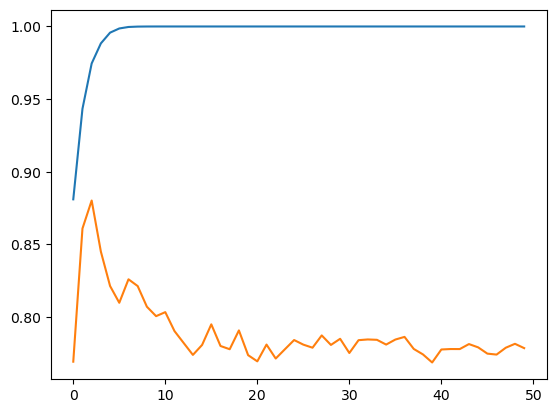

Profundidad óptima: 3
R2 de profundidad óptima: 0.880143959571376


In [17]:
score_train = []
score_test = []

max_depth_optimo = 0
r2_maximo = 0

# Bucle para encontrar la profundidad adecuada del modelo para que este no sobreajuste
for i in range(1, 51):
    
    # Modelo Gradient Boosting Regressor
    gbr = GradientBoostingRegressor(max_depth = i)
    gbr_modelo = gbr.fit(x_train, y_train)
    
    # Predicción con Gradient Boosting Regressor
    y_pred = gbr.predict(x_test)
    
    # Puntuaciones de R2 en entrenamiento y prueba
    score_train.append(gbr.score(x_train, y_train))
    score_test.append(gbr.score(x_test, y_test))
    
    # R2 en conjunto de prueba
    r2 = r2_score(y_test, y_pred)

    # Actualización de la profundidad óptima y el R2 máximo
    if r2 > r2_maximo:
        max_depth_optimo = i
        r2_maximo = r2

# Gráfico con las puntuaciones de R2 en entrenamiento y prueba en función de la profundidad
plt.plot(score_train)
plt.plot(score_test)
plt.show()        

print("Profundidad óptima:", max_depth_optimo)
print("R2 de profundidad óptima:", r2_maximo)

### 3.4 - Modelo de regresión

In [18]:
# Modelo Gradient Boosting Regressor
gbr = GradientBoostingRegressor(max_depth = max_depth_optimo) # Se establece la profundidad máxima óptima calculada
gbr_modelo = gbr.fit(x_train, y_train)

# Predicción con Gradient Boosting Regressor
y_pred = gbr.predict(x_test)

# Métricas del modelo

# R2
r2 = r2_score(y_test, y_pred)
# R2 ajustado
r2_adj = 1-(1-r2)*(len(y_test)-1) / (len(y_test)-len(x.columns)-1)

# Media de los valores reales en el conjunto de prueba
media = y_test.mean()
# MAE (Error absoluto medio)
mae = (abs(y_pred - y_test)).mean()

# Media y desviación típica del conjunto de entrenamiento
y_train_mean = y_train.mean()
y_train_std = y_train.std()
# Normalización de los datos de predicción y de prueba para que no estén en diferentes escalas y el MAPE no se vea afectado
y_pred_normalizado = y_pred * y_train_std + y_train_mean
y_test_normalizado = y_test * y_train_std + y_train_mean
# MAPE (Error porcentual absoluto medio)
mape = mean_absolute_percentage_error(y_test_normalizado, y_pred_normalizado)

print("R2: " + str(r2))
print("R2 Ajustado: " + str(r2_adj))
print("Media: " + str(media))
print("MAE: " + str(mae))
print("MAPE: " + str(mape))

R2: 0.8807166332855086
R2 Ajustado: 0.8750663685464012
Media: 187.575
MAE: 75.93009442327644
MAPE: 22.2144598669044


<div style="border: 5px solid rgba(4, 100, 159, 1); padding: 20px; font-size: 16px; color: #1F2E4E; background-color: rgba(249, 206, 29, 0.2);">
A pesar de que se ha logrado obtener un R² ajustado alto, el MAPE alcanzado es tan elevado que tiene muy poca fiabilidad.
</div>

### 3.5 - Feature Importance

In [19]:
# Importancia de las variables independientes
feature_importance = pd.DataFrame({'variables':x_train.columns, 'feature_importance':gbr_modelo.feature_importances_})
feature_importance = feature_importance.sort_values(by='feature_importance', ascending=False)

round(feature_importance,2)

,variables,feature_importance
4,n_rest_fidelizados_delivery,0.51
3,total_rest_fidelizados,0.33
1,densidad,0.05
7,latitud,0.04
6,poblacion_por_rest,0.03
0,ingreso_medio,0.03
8,longitud,0.01
2,n_rest_delivery,0.01
5,n_rest_fidelizados_no_delivery,0.00


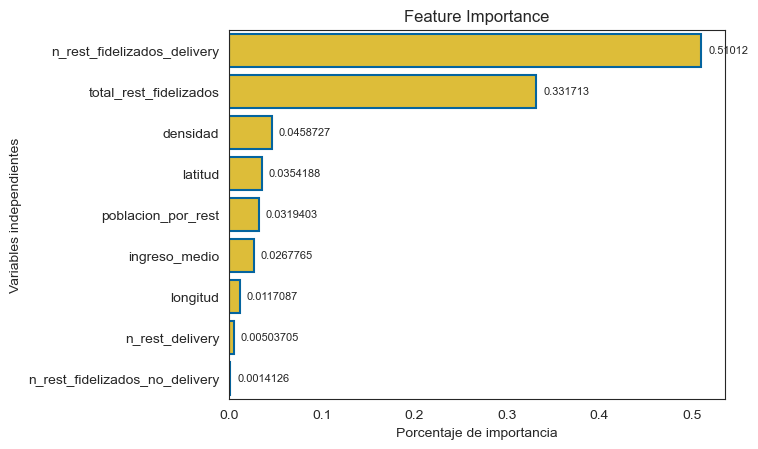

In [20]:
# Gráfico de barras con las Feature Importance de las variables independientes
fig, ax = plt.subplots()
sns.barplot(x='feature_importance', y='variables', data=feature_importance, color='#f9ce1dff', edgecolor=['#04649fff'], linewidth=1.5)

# Etiquetas de los valores
for i, bar in enumerate(ax.containers):
    ax.bar_label(bar, label=feature_importance.feature_importance[i], label_type='edge', fontsize=8, padding=5)

# Título y etiquetas de los ejes
plt.title('Feature Importance')
plt.xlabel('Porcentaje de importancia')
plt.ylabel('Variables independientes')

plt.show()

### 3.6 - SHAP values

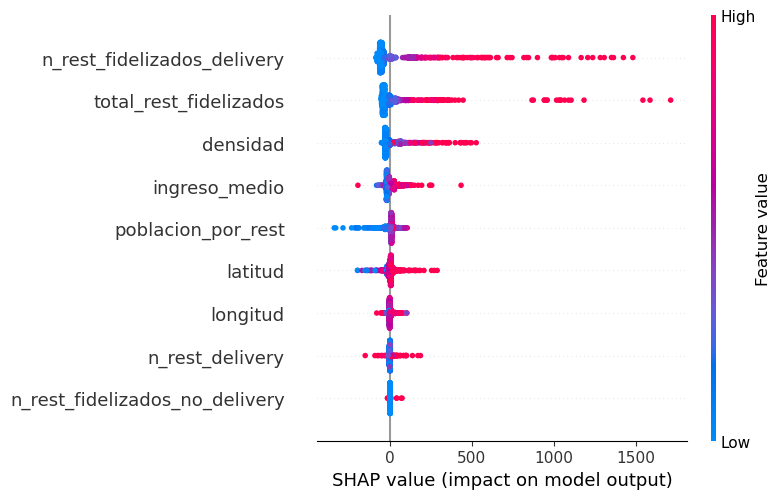

In [21]:
# Valores SHAP del modelo Gradient Boosting Regressor
explainer = shap.Explainer(gbr_modelo, x)
shap_values = explainer.shap_values(x)

shap.summary_plot(shap_values, x)

### 3.7 - Waterfall SHAP

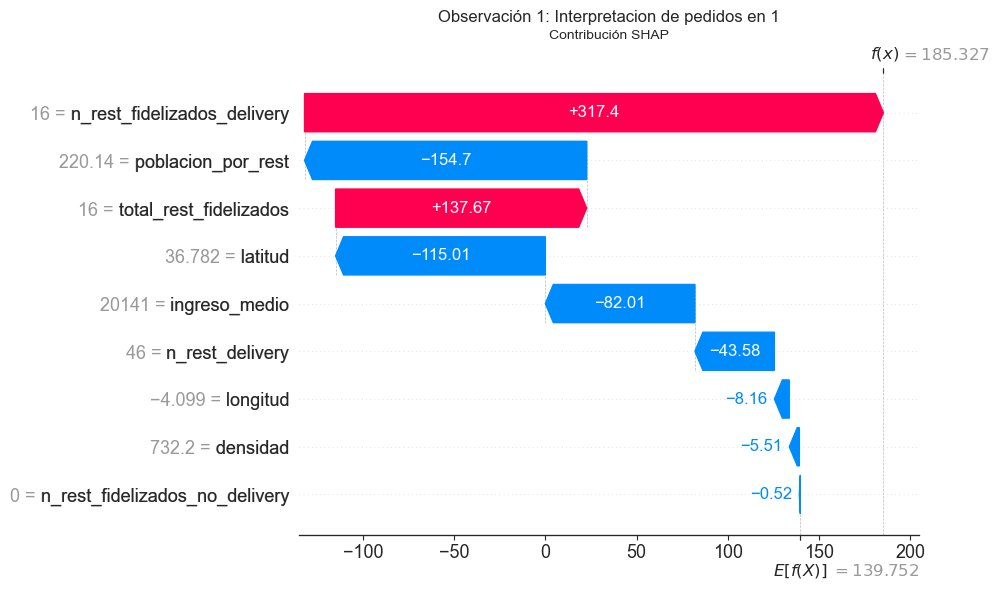

In [22]:
# Waterfall de SHAP para una observación seleccionada
obs_number = 1

shap_values = explainer(x)
shap.plots.waterfall(shap_values[obs_number], max_display=10, show=False)

# Título y etiqueta del eje
plt.title(f'Observación {obs_number}: Interpretacion de pedidos en {x.index[obs_number]}')
plt.xlabel('Contribución SHAP')

plt.show()

### 3.8 - Ciudades con mayor potencial

In [23]:
# Escalado de las variables independientes entre 0 y 1 para poder establecer la potencialidad
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)
x_scaled = pd.DataFrame(x_scaled, columns=x.columns)

# Selección de variables comunes entre 'feature_importance' y 'x_scaled'
variables_dependientes = list(set(feature_importance['variables']) & set(x_scaled.columns))

x_scaled['potencialidad'] = 0

# Bucle para obtener la multiplicación del valor de las variables escaladas por el porcentaje de importancia determinado por Feature Importance
for variable in variables_dependientes:
    
    feature_importance_comunes = feature_importance[feature_importance['variables'] == variable]
    feature_importance_comunes = feature_importance_comunes['feature_importance'].values[0]
    x_scaled['potencialidad'] += feature_importance_comunes * x_scaled[variable]

df_reg = df_reg.merge(x_scaled['potencialidad'], how='left', left_index=True, right_index=True)
df_reg.sample(5)

,ciudad,poblacion,pedidos,densidad,ingreso_medio,total_rest,total_rest_fidelizados,n_rest_delivery,n_rest_fidelizados_delivery,n_rest_no_delivery,n_rest_fidelizados_no_delivery,n_pedidos_por_rest,poblacion_por_rest,poblacion_por_rest_fidelizado,p_rest_fidelizados,latitud,longitud,comunidad_autonoma,potencialidad
26,Fuengirola,74054,3251,7194.00,22054.00,672,51,75,51,597,0,63.75,110.20,1452.04,0.08,36.54,-4.62,Andalucía,0.90
541,Sopelana,12693,336,1532.00,32626.00,35,3,5,3,30,0,112.00,362.66,4231.00,0.09,43.38,-2.98,País Vasco,0.11
750,Campillos,8707,0,46.00,19674.00,31,0,2,0,29,0,0.00,280.87,0.00,0.00,37.05,-4.86,Andalucía,0.04
753,Legazpi,8684,0,282.50,27777.50,26,0,1,0,25,0,0.00,334.00,0.00,0.00,43.05,-2.33,País Vasco,0.05
813,Aranguren,8026,166,148.00,29912.00,26,0,0,0,26,0,0.00,308.69,0.00,0.00,42.78,-1.57,Navarra,0.06


In [24]:
# Ciudades ordenadas de mayor a menor en base al resultado calculado
top_50_ciudades = df_reg.sort_values(by='potencialidad', ascending=False).head(50)['ciudad'].tolist()

top_1 = top_50_ciudades[:25]
top_2 = top_50_ciudades[25:]

# Lista de ciudades con mayor potencialidad
for i, (ciudad1, ciudad2) in enumerate(zip(top_1, top_2)):
    print(f"{i+1}. {ciudad1:<35}{i+26}. {ciudad2}")

1. Fuengirola                         26. Calvià
2. Eivissa                            27. Viladecans
3. Sant Cugat del Vallès              28. Gavà
4. Benalmádena                        29. Estepona
5. Rozas de Madrid, Las               30. Portugalete
6. Mijas                              31. Rubí
7. Torremolinos                       32. Toledo
8. Collado Villalba                   33. Gandia
9. Vilanova i la Geltrú               34. Puerto de Santa María, El
10. San Sebastián de los Reyes         35. Tres Cantos
11. Granollers                         36. Mollet del Vallès
12. Pozuelo de Alarcón                 37. Línea de la Concepción, La
13. Cornellà de Llobregat              38. Getxo
14. Castelldefels                      39. Massanassa
15. Sant Boi de Llobregat              40. Benidorm
16. Palencia                           41. Blanes
17. Sitges                             42. Arteixo
18. Majadahonda                        43. Segovia
19. San Vicente del Raspeig/Sant Vicent 

---
## **4 - 📊 Modelo de clasificación**

### 4.1 - Potencialidad

<div style="border: 5px solid rgba(4, 100, 159, 1); padding: 20px; font-size: 16px; color: #1F2E4E; background-color: rgba(249, 206, 29, 0.2);">
Al tener un MAPE alto en la regresión realizada, se ha decidido convertir la variable objetivo a categórica.
<br><br>
Para ello, se han utilizado los cuartiles para dividir el número de pedidos en cuatro categorías en función de su potencialidad.
</div>

In [25]:
df_clas = df.copy()

# Definición de cuartiles de potencialidad 
q1 = df_clas['pedidos'].quantile(0.25)
q2 = df_clas['pedidos'].quantile(0.5)
q3 = df_clas['pedidos'].quantile(0.75)

df_clas['potencialidad_pedidos'] = df_clas['pedidos']

# Categorizarización de la potencialidad de los pedidos
for i, row in df_clas.iterrows():
    
    if row['pedidos'] <= q1: df_clas.at[i, 'potencialidad_pedidos'] = 'Baja' 
    elif row['pedidos'] <= q2: df_clas.at[i, 'potencialidad_pedidos'] = 'Medio-baja'
    elif row['pedidos'] <= q3: df_clas.at[i, 'potencialidad_pedidos'] = 'Medio-alta'
    else: df_clas.at[i, 'potencialidad_pedidos'] = 'Alta'
    
df_clas['potencialidad_pedidos'].value_counts().to_frame().reindex({'Alta':1, 'Medio-alta':2, 'Medio-baja':3, 'Baja':4}.keys())

,potencialidad_pedidos
Alta,250
Medio-alta,246
Medio-baja,63
Baja,440


### 4.2 - Selección de variables independientes

In [26]:
# Variable dependiente
y = df_clas['potencialidad_pedidos']

# Variables independientes
x = df_clas[[
        'poblacion',
        'ingreso_medio',
        'densidad',
        'n_rest_delivery',
        'total_rest_fidelizados',
        'n_rest_fidelizados_delivery',
        'poblacion_por_rest_fidelizado',
        'p_rest_fidelizados',
        'latitud',
        ]]

# Conjunto de datos de entrenamiento y de prueba
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)

### 4.3 - Ajuste de profundidad

<div style="border: 5px solid rgba(4, 100, 159, 1); padding: 20px; font-size: 16px; color: #1F2E4E; background-color: rgba(249, 206, 29, 0.2);">
A la hora de seleccionar el modelo, se ha obtenido que el Decision Tree es el que mejores resultados en cuanto a precisión, pero, para reducir el sobreajuste al que tiende este modelo, se ha optado por Random Forest.
<br><br>
Elegidas las variables independientes, se ha procedido a encontrar la profundidad óptima, sin sobreajustar el modelo a los datos de entrenamiento y siempre priorizando mantener la máxima precisión en la categoría 'Alta'.
</div>

In [27]:
max_depth_optimo = 0
precision_max_alta = 0

# Bucle para encontrar la profundidad adecuada para que el modelo no sobreajuste
for i in range(1, 51):
    
    # Modelo Random Forest Classifier
    rfc = RandomForestClassifier(max_depth = i)
    rfc_modelo = rfc.fit(x_train, y_train)
    
    # Predicción con Random Forest Classifier
    y_pred = rfc.predict(x_test)
    
    # Precisión de la categoría 'Alta'
    precision_alta = precision_score(y_test, y_pred, labels=['Alta'], average='macro')

    # Actualización de la profundidad óptima y el R2 máximo
    if precision_alta > precision_max_alta:
        max_depth_optimo = i
        precision_max_alta = precision_alta

print("Profundidad óptima:", max_depth_optimo)
print("Precisión máxima de categoría 'Alta':", precision_max_alta)

Profundidad óptima: 4
Precisión máxima de categoría 'Alta': 0.8478260869565217


### 4.4 - Modelo de clasificación

In [28]:
# Modelo Random Forest Classifier
rfc = RandomForestClassifier(max_depth = max_depth_optimo)
rfc_modelo = rfc.fit(x_train, y_train)

# Predicción con Random Forest Classifier
y_pred = rfc.predict(x_test)

# Métricas del modelo

# Precisión general
precision = precision_score(y_test, y_pred, average='weighted').round(2)
# Precisión de la categoría 'Alta'
precision_alta = precision_score(y_test, y_pred, labels=['Alta'], average='weighted').round(2)

# Informe de clasificación
reporte_clasificacion_test = classification_report(y_test, y_pred)
# Matriz de confusión
matriz_confusion_train = confusion_matrix(y_train, rfc.predict(x_train))

print("Precisión: " + str(precision))
print("Precisión de 'Alta': " + str(precision_alta))
print("")

print("Informe de clasificación en test:")
print(reporte_clasificacion_test)
print("")
print("Matriz de confusión en train:")
print(matriz_confusion_train)

Precisión: 0.65
Precisión de 'Alta': 0.81

Informe de clasificación en test:
              precision    recall  f1-score   support

        Alta       0.81      0.81      0.81        48
        Baja       0.72      0.87      0.79        90
  Medio-alta       0.55      0.52      0.53        46
  Medio-baja       0.00      0.00      0.00        16

    accuracy                           0.70       200
   macro avg       0.52      0.55      0.53       200
weighted avg       0.65      0.70      0.67       200


Matriz de confusión en train:
[[167  13  22   0]
 [  1 321  28   0]
 [ 23  62 115   0]
 [  2  27  18   0]]


<div style="border: 5px solid rgba(4, 100, 159, 1); padding: 20px; font-size: 16px; color: #1F2E4E; background-color: rgba(249, 206, 29, 0.2);">
Para evaluar el rendimiento del modelo se ha calculado la tabla de confusión que resume los verdaderos positivos, verdaderos negativos, falsos positivos y falsos negativos en cada categoría.
<br><br>
Dentro de esta tabla, realmente la métrica que más sentido tiene analizar a nivel negocio es la precisión de las ciudades con potencial ‘Alto’.
</div>

### 4.5 - Feature Importance

In [29]:
# Importancia de las variables independientes
feature_importance = pd.DataFrame({'variables':x_train.columns, 'feature_importance':rfc_modelo.feature_importances_})
feature_importance = feature_importance.sort_values(by='feature_importance', ascending=False)

round(feature_importance,2)

,variables,feature_importance
4,total_rest_fidelizados,0.28
5,n_rest_fidelizados_delivery,0.20
6,poblacion_por_rest_fidelizado,0.13
2,densidad,0.12
7,p_rest_fidelizados,0.10
1,ingreso_medio,0.09
8,latitud,0.03
0,poblacion,0.03
3,n_rest_delivery,0.03


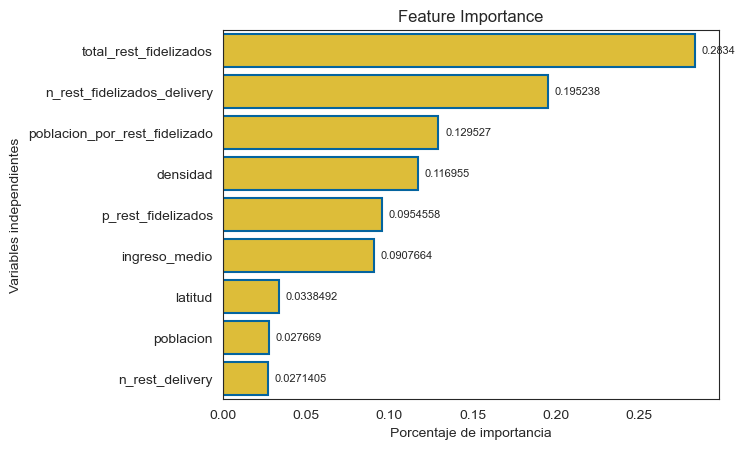

In [30]:
# Gráfico de barras con las Feature Importance de las variables independientes
fig, ax = plt.subplots()
sns.barplot(x='feature_importance', y='variables', data=feature_importance, color='#f9ce1dff', edgecolor=['#04649fff'], linewidth=1.5)

# Etiquetas de los valores
for i, bar in enumerate(ax.containers):
    ax.bar_label(bar, label=feature_importance.feature_importance[i], label_type='edge', fontsize=8, padding=5)

# Título y etiquetas de los ejes
plt.title('Feature Importance')
plt.xlabel('Porcentaje de importancia')
plt.ylabel('Variables independientes')

plt.show()

### 4.6 - SHAP values

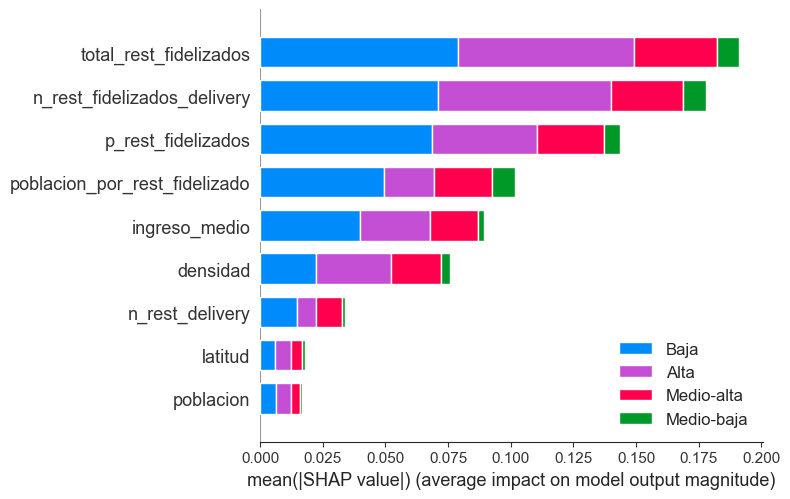

In [31]:
# Valores SHAP del modelo Random Forest Classifier
explainer = shap.Explainer(rfc_modelo, x)
shap_values = explainer.shap_values(x, check_additivity=False)

shap.summary_plot(shap_values, x, class_names=rfc.classes_)

### 4.7 - Ciudades con mayor potencialidad

In [32]:
# Escalado de las variables independientes entre 0 y 1 para poder establecer la potencialidad
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)
x_scaled = pd.DataFrame(x_scaled, columns=x.columns)

# Selección de variables comunes entre 'feature_importance' y 'x_scaled'
variables_dependientes = list(set(feature_importance['variables']) & set(x_scaled.columns))

x_scaled['potencialidad'] = 0

# Bucle para obtener la suma de las multiplicaciones de las variables comunes en feature_importance' y 'x_scaled'
for variable in variables_dependientes:
    
    feature_importance_comunes = feature_importance[feature_importance['variables'] == variable]
    feature_importance_comunes = feature_importance_comunes['feature_importance'].values[0]
    x_scaled['potencialidad'] += feature_importance_comunes * x_scaled[variable]
    
x_scaled.sample(5)

,poblacion,ingreso_medio,densidad,n_rest_delivery,total_rest_fidelizados,n_rest_fidelizados_delivery,poblacion_por_rest_fidelizado,p_rest_fidelizados,latitud,potencialidad
900,0.01,0.04,0.00,0.03,0.00,0.00,0.00,0.00,0.79,0.02
312,0.17,0.67,0.03,0.09,0.06,0.06,0.17,0.35,0.85,0.19
662,0.04,0.65,0.08,0.00,0.00,0.00,0.00,0.00,0.83,0.07
684,0.04,0.17,0.02,0.08,0.00,0.00,0.00,0.00,0.80,0.03
482,0.09,0.21,0.00,0.11,0.04,0.04,0.17,0.12,0.85,0.10


In [33]:
df_clas = df_clas.merge(x_scaled['potencialidad'], how='left', left_index=True, right_index=True)

# Definición de cuartiles de potencialidad
q1 = df_clas['potencialidad'].quantile(0.25)
q2 = df_clas['potencialidad'].quantile(0.5)
q3 = df_clas['potencialidad'].quantile(0.75)

df_clas['potencialidad_cat'] = df_clas['potencialidad']

# Categorizarización de la potencialidad
for i, row in df_clas.iterrows():
    
    if row['potencialidad'] <= q1: df_clas.at[i, 'potencialidad_cat'] = 'Baja' 
    elif row['potencialidad'] <= q2: df_clas.at[i, 'potencialidad_cat'] = 'Medio-baja'
    elif row['potencialidad'] <= q3: df_clas.at[i, 'potencialidad_cat'] = 'Medio-alta'    
    else: df_clas.at[i, 'potencialidad_cat'] = 'Alta'
        
df_clas.sort_values(by='potencialidad', ascending=False).head(5)

,ciudad,poblacion,pedidos,densidad,ingreso_medio,total_rest,total_rest_fidelizados,n_rest_delivery,n_rest_fidelizados_delivery,n_rest_no_delivery,...,n_pedidos_por_rest,poblacion_por_rest,poblacion_por_rest_fidelizado,p_rest_fidelizados,latitud,longitud,comunidad_autonoma,potencialidad_pedidos,potencialidad,potencialidad_cat
26,Fuengirola,74054,3251,7194.00,22054.00,672,51,75,51,597,...,63.75,110.20,1452.04,0.08,36.54,-4.62,Andalucía,Alta,0.68,Alta
0,"Rozas de Madrid, Las",94471,3649,1320.00,36691.67,280,47,57,29,223,...,77.64,337.40,2010.02,0.17,40.56,-3.89,Comunidad de Madrid,Alta,0.67,Alta
11,Sant Cugat del Vallès,83262,1853,3369.62,30060.29,331,44,66,44,265,...,42.11,251.55,1892.32,0.13,41.47,2.08,Cataluña,Alta,0.67,Alta
65,Eivissa,53498,3663,4796.00,25735.00,447,47,70,47,377,...,77.94,119.68,1138.26,0.11,38.97,1.42,Islas Baleares,Alta,0.67,Alta
43,Benalmádena,63789,1545,5866.67,22546.67,496,38,76,38,420,...,40.66,128.61,1678.66,0.08,36.59,-4.57,Andalucía,Alta,0.55,Alta


In [34]:
# Ciudades ordenadas de mayor a menor en base al resultado calculado
top_50_ciudades = df_clas.sort_values(by='potencialidad', ascending=False).head(50)['ciudad'].tolist()

top_1 = top_50_ciudades[:25]
top_2 = top_50_ciudades[25:]

# Lista de ciudades con mayor potencialidad
for i, (ciudad1, ciudad2) in enumerate(zip(top_1, top_2)):
    print(f"{i+1}. {ciudad1:<35}{i+26}. {ciudad2}")

1. Fuengirola                         26. Prat de Llobregat, El
2. Rozas de Madrid, Las               27. Villaviciosa de Odón
3. Sant Cugat del Vallès              28. Viladecans
4. Eivissa                            29. Gavà
5. Benalmádena                        30. Colmenar Viejo
6. Collado Villalba                   31. Arteixo
7. Pozuelo de Alarcón                 32. Sant Adrià de Besòs
8. San Sebastián de los Reyes         33. Getxo
9. Mijas                              34. Galapagar
10. Majadahonda                        35. Línea de la Concepción, La
11. Vilanova i la Geltrú               36. Pontevedra
12. Cornellà de Llobregat              37. Mollet del Vallès
13. Granollers                         38. Rubí
14. Torremolinos                       39. Torrelodones
15. Sant Boi de Llobregat              40. Pinto
16. Castelldefels                      41. Salou
17. Portugalete                        42. Boadilla del Monte
18. Palencia                           43. Esplugues de

---
## **5 - 📊 Modelo de clasificación alternativo**

### 5.1 - Potencialidad alternativa: nº de pedidos por restaurante fidelizado

<div style="border: 5px solid rgba(4, 100, 159, 1); padding: 20px; font-size: 16px; color: #1F2E4E; background-color: rgba(249, 206, 29, 0.2);">
A pesar de haber obtenido un buen resultado en la precisión de la categoría ‘Alta’, se ha querido buscar una variable más significativa en la potencialidad de la ciudad. Como no se cuenta con ningún dato referente a los ingresos, se ha decidido optar por el número de pedidos mensuales que se realizan por restaurante fidelizado en cada ciudad.
</div>

In [35]:
df_clas_alt = df.copy()

# Definición de cuartiles de potencialidad 
q1 = df_clas_alt['n_pedidos_por_rest'].quantile(0.25)
q2 = df_clas_alt['n_pedidos_por_rest'].quantile(0.5)
q3 = df_clas_alt['n_pedidos_por_rest'].quantile(0.75)

df_clas_alt['potencialidad_pedidos_por_rest'] = df_clas_alt['n_pedidos_por_rest']

# Categorizarización de la potencialidad del nº de pedidos por restaurante fidelizado
for i, row in df_clas_alt.iterrows():
    
    if row['n_pedidos_por_rest'] <= q1: df_clas_alt.at[i, 'potencialidad_pedidos_por_rest'] = 'Baja' 
    elif row['n_pedidos_por_rest'] <= q2: df_clas_alt.at[i, 'potencialidad_pedidos_por_rest'] = 'Medio-baja'
    elif row['n_pedidos_por_rest'] <= q3: df_clas_alt.at[i, 'potencialidad_pedidos_por_rest'] = 'Medio-alta'
    else: df_clas_alt.at[i, 'potencialidad_pedidos_por_rest'] = 'Alta'
    
df_clas_alt['potencialidad_pedidos_por_rest'].value_counts().to_frame().reindex({'Alta':1, 'Medio-alta':2, 'Medio-baja':3, 'Baja':4}.keys())

,potencialidad_pedidos_por_rest
Alta,250.00
Medio-alta,206.00
Medio-baja,NaN
Baja,543.00


### 5.2 - Selección de variables independientes

In [36]:
# Variable dependiente
y = df_clas_alt['potencialidad_pedidos_por_rest']

# Variables independientes
x = df_clas_alt[[
        'ingreso_medio', 
        'total_rest',
        'n_rest_fidelizados_no_delivery',
        'poblacion_por_rest',
        'latitud'
        ]]

# Conjunto de datos de entrenamiento y de prueba
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)

### 5.3 - Ajuste de profundidad

<div style="border: 5px solid rgba(4, 100, 159, 1); padding: 20px; font-size: 16px; color: #1F2E4E; background-color: rgba(249, 206, 29, 0.2);">
Se han probado varios modelos de clasificación y el que mejor responde a la predicción de las ciudades con potencialidad alta es el Gradient Boosting, por lo que es el que se ha utilizado.
<br><br>
Como en los modelos anteriores, también se ha buscado la profundidad óptima para obtener el mejor desempeño del modelo para nuestro objetivo.
</div>

In [37]:
max_depth_optimo = 0
precision_max_alta = 0

# Bucle para encontrar la profundidad adecuada para que el modelo no sobreajuste
for i in range(1, 51):
    
    # Modelo Gradient Boosting Classifier
    gbc = GradientBoostingClassifier(max_depth = i)
    gbc_modelo = gbc.fit(x_train, y_train)
    
    # Predicción con Gradient Boosting Classifier
    y_pred = gbc.predict(x_test)
    
    # Precisión de la categoría 'Alta'
    precision_alta = precision_score(y_test, y_pred, labels=['Alta'], average='macro')

    # Actualización de la profundidad óptima y el R2 máximo
    if precision_alta > precision_max_alta:
        max_depth_optimo = i
        precision_max_alta = precision_alta

print("Profundidad óptima:", max_depth_optimo)
print("Precisión máxima de categoría 'Alta':", precision_max_alta)

Profundidad óptima: 3
Precisión máxima de categoría 'Alta': 0.7352941176470589


### 5.4 - Modelo de clasificación

In [38]:
# Modelo Gradient Boosting Classifier
gbc = GradientBoostingClassifier(max_depth = max_depth_optimo)
gbc_modelo = gbc.fit(x_train, y_train)

# Predicción con Gradient Boosting Classifier
y_pred = gbc.predict(x_test)

# Métricas del modelo

# Precisión general
precision = precision_score(y_test, y_pred, average='weighted').round(2)
# Precisión de la categoría 'Alta'
precision_alta = precision_score(y_test, y_pred, labels=['Alta'], average='weighted').round(2)

# Informe de clasificación
reporte_clasificacion_test = classification_report(y_test, y_pred)
# Matriz de confusión
matriz_confusion_train = confusion_matrix(y_train, gbc.predict(x_train))

print("Precisión: " + str(precision))
print("Precisión de 'Alta': " + str(precision_alta))
print("")

print("Informe de clasificación en test:")
print(reporte_clasificacion_test)
print("")
print("Matriz de confusión en train:")
print(matriz_confusion_train)

Precisión: 0.65
Precisión de 'Alta': 0.74

Informe de clasificación en test:
              precision    recall  f1-score   support

        Alta       0.74      0.52      0.61        48
        Baja       0.74      0.87      0.80       113
  Medio-alta       0.29      0.26      0.27        39

    accuracy                           0.67       200
   macro avg       0.59      0.55      0.56       200
weighted avg       0.65      0.67      0.65       200


Matriz de confusión en train:
[[177  21   4]
 [  8 415   7]
 [  9  35 123]]


<div style="border: 5px solid rgba(4, 100, 159, 1); padding: 20px; font-size: 16px; color: #1F2E4E; background-color: rgba(249, 206, 29, 0.2);">
Nuevamente, se ha elaborado una tabla de confusión que resume los resultados correctos e incorrectos del modelo en cada categoría, mostrando el número de verdaderos positivos, verdaderos negativos, falsos positivos y falsos negativos.
<br><br>
Al estar enfocados en ciudades con potencial 'Alto’, lo más importante vuelve a ser la precisión de esa categoría. Por lo tanto, esa es la métrica que se ha de analizar cuidadosamente para tomar decisiones informadas en el negocio del delivery.
</div>

### 5.5 - Feature Importance

In [39]:
# Importancia de las variables independientes
feature_importance = pd.DataFrame({'variables':x_train.columns, 'feature_importance':gbc_modelo.feature_importances_})
feature_importance = feature_importance.sort_values(by='feature_importance', ascending=False)

round(feature_importance,2)

,variables,feature_importance
1,total_rest,0.35
0,ingreso_medio,0.27
4,latitud,0.19
3,poblacion_por_rest,0.18
2,n_rest_fidelizados_no_delivery,0.01


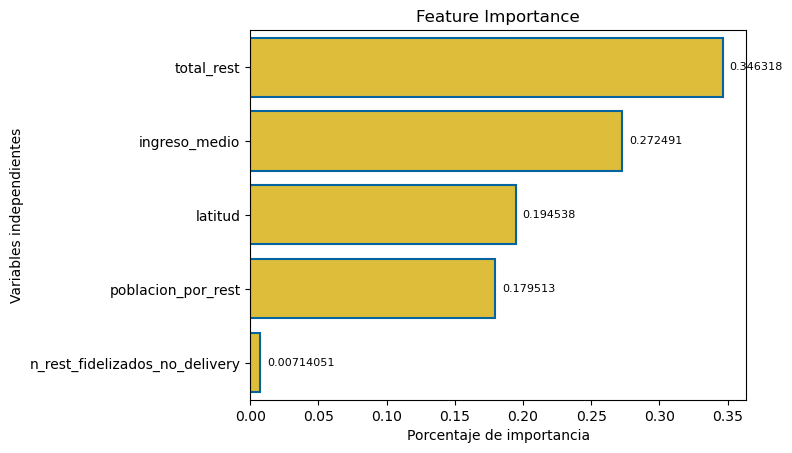

In [40]:
# Gráfico de barras con las Feature Importance de las variables independientes
fig, ax = plt.subplots()
sns.barplot(x='feature_importance', y='variables', data=feature_importance, color='#f9ce1dff', edgecolor=['#04649fff'], linewidth=1.5)

# Etiquetas de los valores
for i, bar in enumerate(ax.containers):
    ax.bar_label(bar, label=feature_importance.feature_importance[i], label_type='edge', fontsize=8, padding=5)

# Título y etiquetas de los ejes
plt.title('Feature Importance')
plt.xlabel('Porcentaje de importancia')
plt.ylabel('Variables independientes')

plt.show()

### 5.6 - SHAP values

In [41]:
"""
# Valores SHAP del modelo
explainer = shap.TreeExplainer(gbc_modelo, x)
shap_values = explainer.shap_values(x)

shap.summary_plot(shap_values, x, class_names=rfc.classes_)
"""
print("")
# SHAP Values para Gradient Boosting Classifier sólo soporta ahora mismo clasificación binaria, por lo que para este caso no se puede realizar

### 5.7 - Ciudades con mayor potencialidad

In [42]:
# Escalado de las variables independientes entre 0 y 1 para poder establecer la potencialidad
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)
x_scaled = pd.DataFrame(x_scaled, columns=x.columns)

# Selección de variables comunes entre 'feature_importance' y 'x_scaled'
variables_dependientes = list(set(feature_importance['variables']) & set(x_scaled.columns))

x_scaled['potencialidad'] = 0

# Bucle para obtener la suma de las multiplicaciones de las variables comunes en feature_importance' y 'x_scaled'
for variable in variables_dependientes:
    
    feature_importance_comunes = feature_importance[feature_importance['variables'] == variable]
    feature_importance_comunes = feature_importance_comunes['feature_importance'].values[0]
    x_scaled['potencialidad'] += feature_importance_comunes * x_scaled[variable]
    
x_scaled.sample(5)

,ingreso_medio,total_rest,n_rest_fidelizados_no_delivery,poblacion_por_rest,latitud,potencialidad
75,0.22,0.59,0.00,0.03,0.81,0.43
195,0.33,0.20,0.00,0.06,0.82,0.33
574,0.17,0.04,0.00,0.15,0.80,0.24
968,0.26,0.02,0.00,0.13,0.84,0.26
977,0.41,0.02,0.00,0.12,0.84,0.30


In [43]:
df_clas_alt = df_clas_alt.merge(x_scaled['potencialidad'], how='left', left_index=True, right_index=True)

# Definición de cuartiles de potencialidad
q1 = df_clas_alt['potencialidad'].quantile(0.25)
q2 = df_clas_alt['potencialidad'].quantile(0.5)
q3 = df_clas_alt['potencialidad'].quantile(0.75)

df_clas_alt['potencialidad_cat'] = df_clas_alt['potencialidad']

# Categorizarización de la potencialidad
for i, row in df_clas_alt.iterrows():
    
    if row['potencialidad'] <= q1: df_clas_alt.at[i, 'potencialidad_cat'] = 'Baja' 
    elif row['potencialidad'] <= q2: df_clas_alt.at[i, 'potencialidad_cat'] = 'Medio-baja'
    elif row['potencialidad'] <= q3: df_clas_alt.at[i, 'potencialidad_cat'] = 'Medio-alta'    
    else: df_clas_alt.at[i, 'potencialidad_cat'] = 'Alta'
        
df_clas_alt.sort_values(by='potencialidad', ascending=False).head(5)

,ciudad,poblacion,pedidos,densidad,ingreso_medio,total_rest,total_rest_fidelizados,n_rest_delivery,n_rest_fidelizados_delivery,n_rest_no_delivery,...,n_pedidos_por_rest,poblacion_por_rest,poblacion_por_rest_fidelizado,p_rest_fidelizados,latitud,longitud,comunidad_autonoma,potencialidad_pedidos_por_rest,potencialidad,potencialidad_cat
0,"Rozas de Madrid, Las",94471,3649,1320.00,36691.67,280,47,57,29,223,...,77.64,337.40,2010.02,0.17,40.56,-3.89,Comunidad de Madrid,Alta,0.58,Alta
26,Fuengirola,74054,3251,7194.00,22054.00,672,51,75,51,597,...,63.75,110.20,1452.04,0.08,36.54,-4.62,Andalucía,Alta,0.56,Alta
31,Benidorm,71309,800,9036.00,20727.33,698,17,38,17,660,...,47.06,102.16,4194.65,0.02,38.54,-0.13,Comunidad Valenciana,Alta,0.56,Alta
32,Majadahonda,71024,1557,3461.67,36409.33,261,34,38,14,223,...,45.79,272.12,2088.94,0.13,40.47,-3.87,Comunidad de Madrid,Alta,0.56,Alta
13,Pozuelo de Alarcón,82916,3108,2515.50,35150.00,275,37,37,21,238,...,84.00,301.51,2240.97,0.13,40.43,-3.81,Comunidad de Madrid,Alta,0.55,Alta


In [44]:
# Ciudades ordenadas de mayor a menor en base al resultado calculado
top_50_ciudades = df_clas_alt.sort_values(by='potencialidad', ascending=False).head(50)['ciudad'].tolist()

top_1 = top_50_ciudades[:25]
top_2 = top_50_ciudades[25:]

# Lista de ciudades con mayor potencialidad
for i, (ciudad1, ciudad2) in enumerate(zip(top_1, top_2)):
    print(f"{i+1}. {ciudad1:<35}{i+26}. {ciudad2}")

1. Rozas de Madrid, Las               26. Palencia
2. Fuengirola                         27. Puerto de Santa María, El
3. Benidorm                           28. Torrelodones
4. Majadahonda                        29. Santa Eulalia del Río
5. Pozuelo de Alarcón                 30. Avilés
6. San Sebastián de los Reyes         31. Aramaio
7. Arona                              32. Lloret de Mar
8. Tres Cantos                        33. Irun
9. Sant Cugat del Vallès              34. Mijas
10. Adeje                              35. Galapagar
11. San Bartolomé de Tirajana          36. Vilanova i la Geltrú
12. Boadilla del Monte                 37. Valdemoro
13. Toledo                             38. Sant Boi de Llobregat
14. Calvià                             39. Chiclana de la Frontera
15. Getxo                              40. Cambrils
16. Eivissa                            41. Aranjuez
17. Villaviciosa de Odón               42. Sitges
18. Castelldefels                      43. Ponferrada
19